<img src="./images/Logo1.png" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="700 px" align="center">

# 第五章 IBM Qで量子プログラムを実行する

## 本章の内容

[全体目次](./Contents.ipynb)

1. [Qiskitで量子プログラムを設計する](#1.-Qiskitで量子プログラムを設計する)
    1. [量子回路を定義する](#1-A.-量子回路を定義する)
    2. [Aerで量子計算をシミュレーションする](#1-B.-Aerで量子計算をシミュレーションする)
2. [IBM Qで実行する](#2.-IBM-Qで実行する)
    1. [量子コンピュータ情報を取得する](#2-A.-量子コンピュータ情報を取得する)
    2. [ジョブを送信する](#2-B.-ジョブを送信する)
    3. [ノイズシミュレーション](#2-C.-ノイズシミュレーション)

このノートブックでは、実際にIBM Qを使って量子プログラムを実行してみます。 $\newcommand{\ket}[1]{\left|{#1}\right\rangle}
\newcommand{\bra}[1]{\left\langle{#1}\right|}
\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$

In [1]:
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

## 1. Qiskitで量子プログラムを設計する

Qiskitは、大きく4つの要素から構成されています。

- Qiskit Terra
- Qiskit Aer
- Qiskit Ignis
- Qiskit Aqua

**Qiskit Terra**は、量子プログラムの基礎となる要素です。量子プログラムを回路とパルスのレベルに構成し、デバイスの制約に合わせて最適化し、リモートでのバッチ実行の管理などを行います。

**Qiskit Aer**は、古典的プロセッサを用いた量子計算のシミュレーションを行います。Aerを使用することで、量子コンピュータが正しく機能していることを確認できます。

**Qiskit Ignis**は、量子誤り訂正符号といった、ノイズとエラーに関する計算機能が含まれます。

**Qiskit Aqua**は、NISQコンピュータ用のアルゴリズムが構築されている場所です。

今回は、TerraとAerの機能、そしてIBM Qを用いていきます。

### 1-A. 量子回路を定義する

実際にQiskitで量子回路を定義していきます。まず、3つの量子ビットからなる空の量子回路を定義します。

In [2]:
from qiskit import QuantumCircuit, QuantumRegister

q = QuantumRegister(3, 'q')
q_circ = QuantumCircuit(q)

この量子回路に、ゲートを追加していきます。試しに、アダマールゲートと2つのCNOTゲートからなるゲート計算を追加します。`draw`メソッドを用いることで回路図を描画することができます。

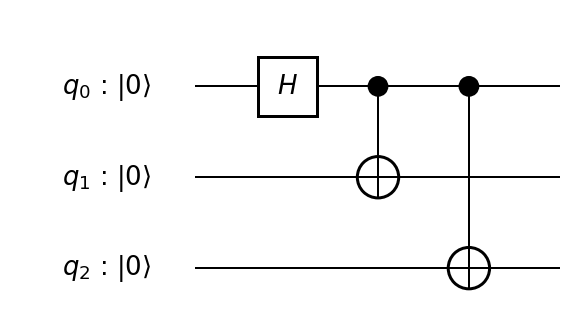

In [3]:
q_circ.h(q[0])
q_circ.cx(q[0], q[1])
q_circ.cx(q[0], q[2])
q_circ.draw(output='mpl')

見ての通り初期の量子ビットの状態は$\ket{0}$です。

次に、この量子ビットを観測するために、古典ビットを追加し、観測を定義します。古典ビットの初期値は$0$です。

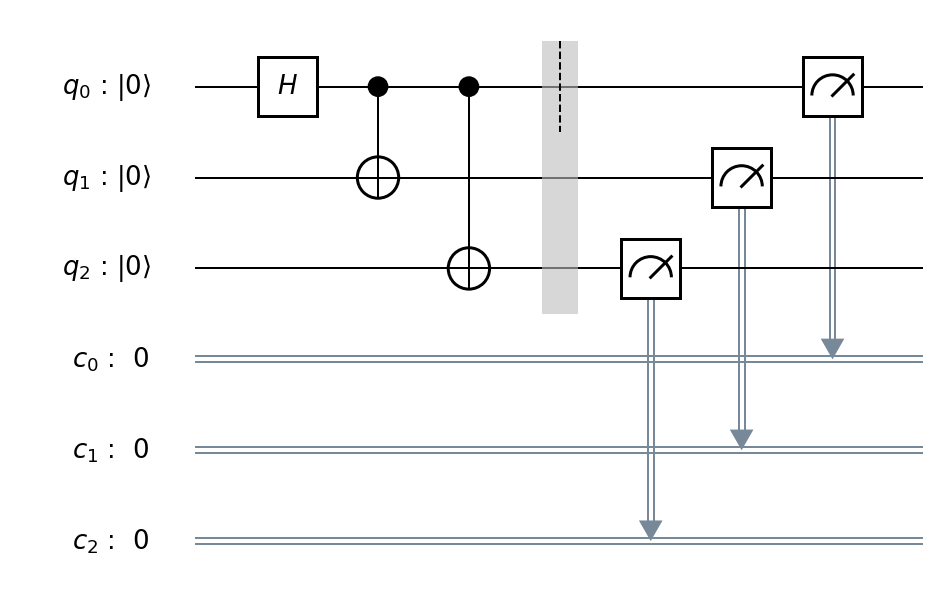

In [4]:
from qiskit import ClassicalRegister

c = ClassicalRegister(3, 'c')

m_circ = QuantumCircuit(q, c)
m_circ.barrier(q) # 最適化によるゲートの並び替えを防ぐためにバリアを設定します
m_circ.measure(q,c)

circ = q_circ + m_circ
circ.draw(output='mpl')

これで量子回路の設計は完了です。とても簡単ですね！

### 1-B. Aerで量子計算をシミュレーションする

いきなり実機で実行する前に、回路の動作を計算して、シミュレータで確認してみましょう。

アダマールゲートにより$q_0$は50%の確率で$0$か$1$が観測されるでしょう（CNOTゲートではコントロールビットは変化しません）。そして、CNOTは$q_0$の状態に応じてビットが反転します。よって、$q_0$が$0$なら$q_1,q_2$も$0$、$q_0$が$1$なら$q_1,q_2$も$1$になるはずです。

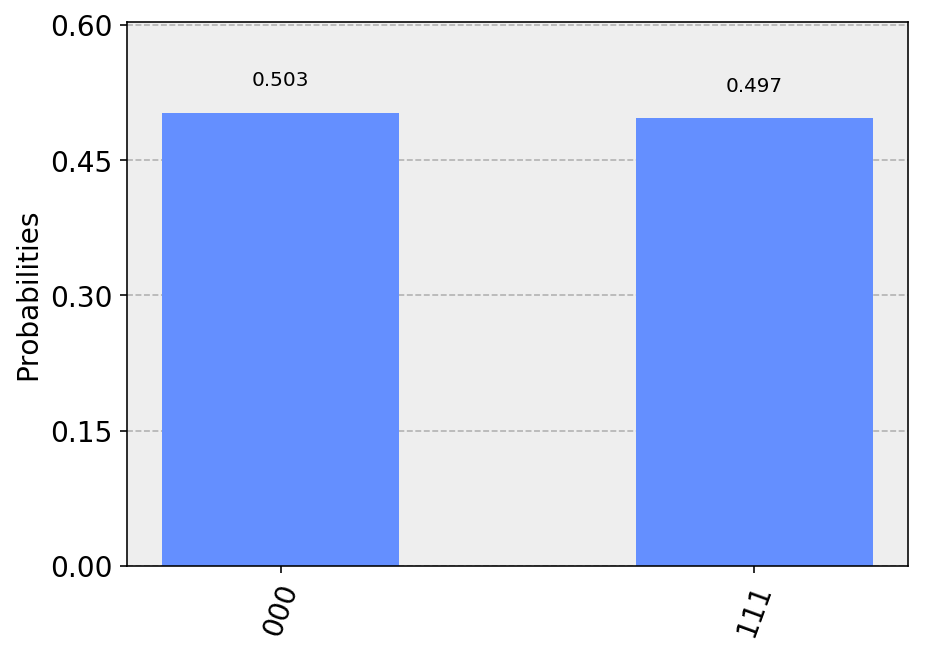

In [6]:
from qiskit import execute, Aer
from qiskit.tools.visualization import plot_histogram

backend_aer = Aer.get_backend('qasm_simulator')
job_aer     = execute(circ, backend_aer, shots=1024) # shotsは、反復実行する回数
result_aer  = job_aer.result()
counts_aer  = result_aer.get_counts(circ)

plot_histogram([counts_aer])

実行するたびに結果は異なりますが、おそらく約50%ずつの確率で`000` か`111`が観測される結果となったはずです。

## 2. IBM Qで実行する

では、この回路をIBM Qで実行しましょう。まずIBM Qアカウントを読み込みます。

In [7]:
from qiskit import IBMQ
IBMQ.load_accounts()

### 2-A. 量子コンピュータ情報を取得する

無料で利用可能なIBM Qデバイスはいくつかあるので、確認してみましょう。

In [8]:
for device in IBMQ.backends():
    conf = device.configuration()
    print(f'[{device}]\n- n_qubits  : {conf.n_qubits}\n- simulator : {conf.simulator}\n')

[ibmqx4]
- n_qubits  : 5
- simulator : False

[ibmqx2]
- n_qubits  : 5
- simulator : False

[ibmq_16_melbourne]
- n_qubits  : 14
- simulator : False

[ibmq_qasm_simulator]
- n_qubits  : 32
- simulator : True



必要な量子ビット数、混み具合やメンテナンスなどで最適なデバイスは異なります。`least_busy`で空いているバックエンドを選択できるので、使うバックエンドを取得しましょう。

In [9]:
from qiskit.providers.ibmq import least_busy

def filter_device(dev):
    """ 4-qubits以上の実機のみに絞ります """
    conf = dev.configuration()
    return conf.n_qubits > 4 and not conf.simulator

ibmq_devices = IBMQ.backends(filters=filter_device)
backend_ibmq = least_busy(ibmq_devices)
print(f'The best backend is "{backend_ibmq.name()}"')

The best backend is "ibmqx2"


### 2-B. ジョブを送信する

選ばれたバックエンドで回路を実行してみましょう！シミュレータと異なり、バッチ処理が完了するまでジョブを待つ必要があります。空いているときはすぐに終わりますが、混雑しているときは時間がかかる場合があります。

In [14]:
job = execute(circ,
              backend     = backend_ibmq,
              shots       = 1024,
              max_credits = 3)

ジョブのIDを控えておきましょう。もしノートブックがダウンしてしまったり、誤ってジョブ変数を上書きしたときなど、あとからジョブを再取得するために必要になります。

In [11]:
job.job_id()

'5c9321fc7c65f800669f0521'

もし再取得するときは以下のようにします。

In [10]:
job = backend_ibmq.retrieve_job('5c9321fc7c65f800669f0521')
#job = backend_ibmq.retrieve_job('ジョブのID')

ジョブの状態は`status`で確認できます。

In [11]:
job_status = job.status()
print(f'{job_status.name}: {job_status.value}')

DONE: job has successfully run


`job_monitor`を使えばジョブが完了するまで状態を表示して待機することができますが、その間ノートブックは他の実行ができません。

```python
from qiskit.tools.monitor import job_monitor

job_monitor(job)
result = job.result()
```

### 2-C. ノイズシミュレーション

おそらく少し時間がかかるので、その間に、古典的コンピュータでノイズありのシミュレーションをしてみましょう。先程決定したIBM Qデバイスバックエンドからノイズ等の情報を取得し、ノイズをシミュレーションしてみます。

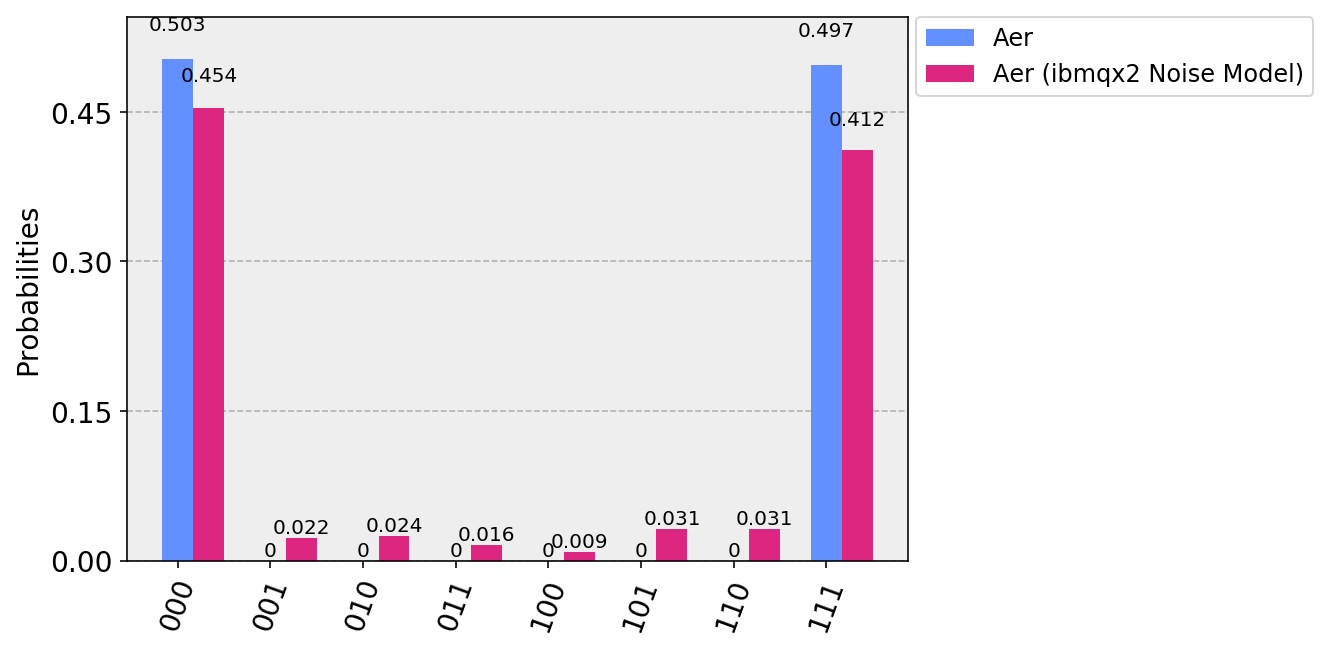

In [12]:
from qiskit.providers.aer import noise

properties   = backend_ibmq.properties()
coupling_map = backend_ibmq.configuration().coupling_map
noise_model  = noise.device.basic_device_noise_model(properties)
basis_gates  = noise_model.basis_gates

job_aer_noisy = execute(circ,
                        backend      = backend_aer,
                        shots        = 1024,
                        coupling_map = coupling_map,
                        noise_model  = noise_model,
                        basis_gates  = noise_model.basis_gates)
result_aer_noisy = job_aer_noisy.result()
counts_aer_noisy = result_aer_noisy.get_counts(circ)

plot_histogram(
    [counts_aer, counts_aer_noisy],
    legend=['Aer',f'Aer ({backend_ibmq.name()} Noise Model)'])

では、ジョブの実行完了を待機し、結果をシミュレーション結果と合わせて確認してみましょう。

HTML(value="<p style='font-size:16px;'>Job Status: job has successfully run </p>")

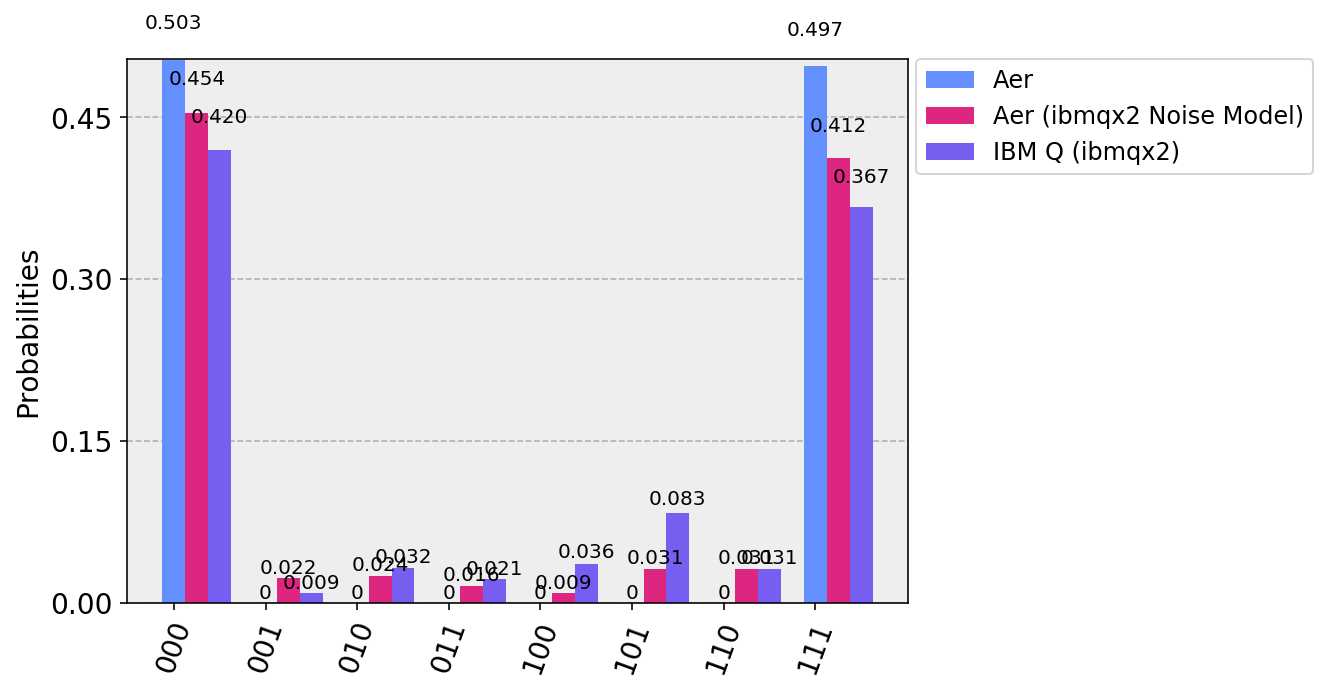

In [14]:
from qiskit.tools.monitor import job_monitor

job_monitor(job)
result = job.result()
counts = result.get_counts()

plot_histogram(
    [counts_aer, counts_aer_noisy, counts],
    legend=['Aer',f'Aer ({backend_ibmq.name()} Noise Model)',f'IBM Q ({backend_ibmq.name()})'])

　
### 　　　　　　　　[前の章へ](./4_measurement.ipynb)　[全体目次](./Contents.ipynb)　 [次の章へ](./6_ibm_q.ipynb)